In [1]:
from testproblems import generate_random_prob
from representations import bipartite_repr
from inputresolver import resolve,invert_edges,getallvars,direct_eqs
from datastructures.polycasebuilder import eqv_to_edges_tree
from datastructures.graphutils import flat_graph_formulation, draw_graph_graphical_props, VAR, COMP, SOLVER, Node, namefromid, copy_dicts
from datastructures.operators import sort_scc, reorder_merge_solve
#from networkx.algorithms.bipartite import random_graph as bipartite_random_graph

In [2]:
from datastructures.tearing import min_max_scc, dir_graph
from datastructures.rendering import render_incidence, incidence_artifacts
from datastructures.graphutils import all_edges, edges_to_Ein_Eout
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import chain

# Parameters

In [3]:
n_eqs = 10
n_vars = 13
seed = 10#8 is triang#seed 10 is nice 42
sparsity = 1.7#0.87#0.8 1.1 #1.7 1.3

# Setup

In [4]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}

In [5]:
namingfunc = namefromid(nodetyperepr)

# Original indexation

In [6]:
eqv, varinc, output_idx = generate_random_prob(n_eqs, n_vars, seed, sparsity)
_, edges_original = bipartite_repr(eqv)
eqs = direct_eqs(eqv, output_idx)
varidxs = getallvars(eqs, sympy=False)
eqnidxs = set(eqs.keys())

# Pretty indexation

In [7]:
output_reidx = {key:var-n_eqs for key,var in output_idx.items()}
edges, tree = eqv_to_edges_tree(eqv, output_reidx, n_eqs)

# Original

In [8]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
maxscc = max([len(elt) for elt in merge_order])

# Optimal scc

In [9]:
optim_edges = list(dir_graph(edges_original, varidxs))

In [10]:
maxl, xsol, m = min_max_scc(optim_edges, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [11]:
maxl

2.0

In [12]:
selected = dict((left, right-n_eqs) for left, right in optim_edges if xsol[left, right] > 0.5)

In [13]:
selected

{0: 4, 1: 0, 2: 8, 3: 5, 4: 1, 5: 6, 6: 3, 7: 11, 8: 10, 9: 7}

In [14]:
Ein, Eout, Rin = copy_dicts(edges)
_, Stree, Vtree = copy_dicts(tree)
Eout_minassign = Eout.copy()
Ein_minassign = Ein.copy()
for comp in Eout.keys():
    if comp in selected:
        var = selected[comp]
        Eout_minassign[comp] = (var,)
        Ein_minassign[comp] = tuple(elt for elt in chain(Ein[comp],Eout[comp]) if elt!=var)
    else:
        old_out_var = Eout[comp][0]
        Eout_minassign[comp] = (None,)
        Ein_minassign[comp] = tuple(elt for elt in chain(Ein[comp],Eout[comp]))

In [15]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges_minassign = Ein_minassign, Eout_minassign, dict()
G2 = flat_graph_formulation(*edges_minassign, nodetyperepr=nodetyperepr)

In [16]:
minassign_order = sort_scc(G2)

In [17]:
minassign_order

[{f_{3}},
 {f_{9}},
 {f_{7}},
 {f_{2}, f_{4}},
 {f_{0}},
 {f_{1}},
 {f_{6}},
 {f_{8}},
 {f_{5}}]

In [18]:
nedges, ntree = reorder_merge_solve(edges_minassign, tree, minassign_order, 1)

In [19]:
#Ftree_mina = OrderedDict([(elt.name,'solver') for comp in minassign_order for elt in comp])

In [20]:
ntree

(OrderedDict([(3, 1),
              (9, 1),
              (7, 1),
              (4, 2),
              (2, 2),
              (0, 1),
              (1, 1),
              (6, 1),
              (8, 1),
              (5, 1)]),
 {2: 1},
 {1: 2, 8: 2})

## Visualize

In [90]:
from datastructures.workflow import order_from_tree, SOLVER, COMP, ENDCOMP, path
from datastructures.graphutils import end_components, solver_children
from collections import defaultdict

In [72]:
def handle_component(allendcomps, queue, component, parent, endcompqueue, mergeendcomp=True):
    remainingcomps = len([elt for elt in solver_children(queue, parent)])
    lastchildcomp = remainingcomps==0
    if lastchildcomp:
        if mergeendcomp:
            lastcomponent = [component] if component in allendcomps else []
            endcomps_ids = endcompqueue+lastcomponent
            if endcomps_ids:
                endcomps = [(ENDCOMP, endcomps_ids, parent)]
            else:
                endcomps = []
        else:
            lastcomponent = [(ENDCOMP, component, parent)] if component in allendcomps else []
            endcomps = [(ENDCOMP, comps, parent) for comps in endcompqueue]+lastcomponent
        if component not in allendcomps:
            return [(COMP, component, parent)] + endcomps, []
        else:
            return endcomps, []
    if component not in allendcomps: 
           return [(COMP, component, parent)], endcompqueue
    else:
        return None, endcompqueue+[component]

In [84]:
Ftree = [(0,0), (1,1),(2,2),(3,2),(4,1,),(5,1),(6,1),(7,0),(8,0)]
Stree = {2:1, 1:0}
endcomps = {comp: comp in [0,2,5,6] for comp,_ in Ftree}

In [101]:
includesolver = True
mergeendcomp = True

In [102]:
visited_solvers = set()
sequence = []
endcompqueue = defaultdict(list)
queue = list(Ftree)
while queue:
    component, parent = queue.pop(0)
    ancestors = path(Stree, parent, visited_solvers)
    reverse_ancestors = ancestors[::-1]
    visited_solvers = visited_solvers.union(reverse_ancestors)
    if includesolver:
        sequence += [(SOLVER, solver, Stree.get(solver,None)) for solver in reverse_ancestors]
    if endcomps[component]:
        endcompqueue[parent].append(component)
    else:
        sequence += [(COMP, component, parent)]
    remainingcomps = len([elt for elt in solver_children(dict(queue), parent)])
    lastchildcomp = remainingcomps==0
    if lastchildcomp:
        if mergeendcomp:
            sequence += [(ENDCOMP, endcompqueue[parent], parent)]
        else:
            sequence += [(ENDCOMP, endcomp, parent) for endcomp in endcompqueue[parent]]

In [103]:
sequence

[(SOLVER, 0, None),
 (SOLVER, 1, 0),
 (COMP, 1, 1),
 (SOLVER, 2, 1),
 (COMP, 3, 2),
 (ENDCOMP, [2], 2),
 (COMP, 4, 1),
 (ENDCOMP, [5, 6], 1),
 (COMP, 7, 0),
 (COMP, 8, 0),
 (ENDCOMP, [0], 0)]

In [ ]:
order = []
for elt in Ftree

In [68]:
order = sorted((idx, solver, endcomps[comp], comp) for idx, (comp, solver) in enumerate(Ftree))

In [ ]:
while 

In [69]:
order

[(0, 1, False, 'a'),
 (1, 2, True, 'b'),
 (2, 2, False, 'c'),
 (3, 1, False, 'd'),
 (4, 1, True, 'e'),
 (5, 1, True, 'f'),
 (6, 0, False, 'g'),
 (7, 0, False, 'h')]

In [33]:
endcomp = {key: None in var for key,var in nedges[1].items()}

In [34]:
endcomp

{1: False,
 3: False,
 2: True,
 4: True,
 7: False,
 9: False,
 5: False,
 6: False,
 0: False,
 8: False}

In [49]:
order

[(0, 1, False, 3),
 (1, 1, False, 9),
 (2, 1, False, 7),
 (3, 2, True, 4),
 (4, 2, True, 2),
 (5, 1, False, 0),
 (6, 1, False, 1),
 (7, 1, False, 6),
 (8, 1, False, 8),
 (9, 1, False, 5)]

In [27]:
ntree[1]

{2: 1}

In [95]:
order_from_tree(ntree[0], ntree[1], nedges[1], includesolver=True, mergeendcomp=True)

[(SOLVER, 1, None),
 (COMP, 3, 1),
 (COMP, 9, 1),
 (COMP, 7, 1),
 (COMP, 0, 1),
 (COMP, 1, 1),
 (COMP, 6, 1),
 (COMP, 8, 1),
 (COMP, 5, 1),
 (SOLVER, 2, 1),
 (ENDCOMP, [4, 2], 2)]

In [42]:
sequence, permutation, Ein, Eout, solver_iterator = incidence_artifacts(nedges, ntree, True)

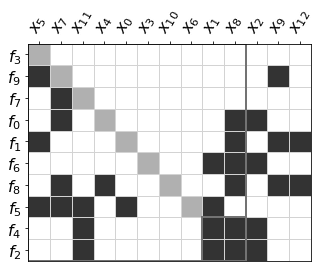

In [44]:
_, ax = render_incidence(nedges, ntree, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'minscc_10x13.png', dpi=300, bbox_inches='tight')